##Cell 1 – Title & intro (Markdown)

# K-Means Clustering from Scratch (with Synthetic Data)

In this notebook I:

1. Generate a small 2D synthetic dataset with 3 natural clusters.
2. Implement **K-Means clustering from scratch** using NumPy:
   - random centroid initialization
   - assignment step (closest centroid)
   - update step (move centroids to cluster means)
   - convergence check
3. Visualize the results and compare with `sklearn`'s `KMeans`.


# Cell 2 – Imports & synthetic data

Data shape: (150, 2)


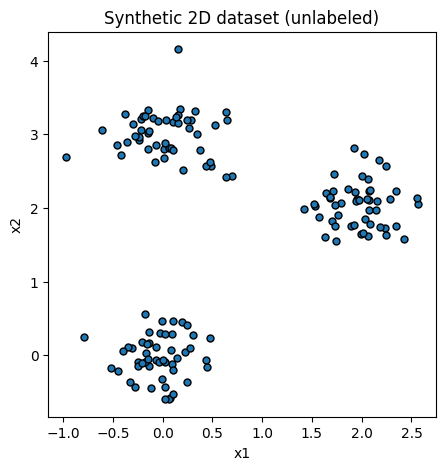

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans as SkKMeans  # just for comparison at the end
from sklearn.metrics import silhouette_score

np.random.seed(42)

# ---- Generate a tiny synthetic 2D dataset with 3 blobs ----
n_points = 50  # per cluster

cluster1 = np.random.normal(loc=[0, 0], scale=0.3, size=(n_points, 2))
cluster2 = np.random.normal(loc=[2, 2], scale=0.3, size=(n_points, 2))
cluster3 = np.random.normal(loc=[0, 3], scale=0.3, size=(n_points, 2))

X = np.vstack([cluster1, cluster2, cluster3])

print("Data shape:", X.shape)

# Quick scatter plot of the raw data
plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], s=25, edgecolor="k")
plt.title("Synthetic 2D dataset (unlabeled)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


# Cell 3 – Explanation of K-Means (Markdown)

## How K-Means Works (Quick Recap)

K-Means tries to partition the data into **K clusters** by minimizing the
sum of squared distances from each point to its assigned cluster centroid.

Algorithm steps:
1. **Initialize** K centroids (e.g., randomly chosen data points).
2. **Assign step**: for each point, find the nearest centroid → assign a cluster label.
3. **Update step**: recompute each centroid as the mean of the points assigned to it.
4. Repeat 2–3 until centroids stop moving (or max iterations reached).

We’ll now implement this **from scratch** using NumPy.


# Cell 4 – K-Means from scratch implementation

In [3]:
def initialize_centroids(X, k):
    """
    Initialize centroids by randomly choosing k points from X.
    X: (n_samples, n_features)
    return: (k, n_features)
    """
    n_samples = X.shape[0]
    indices = np.random.choice(n_samples, size=k, replace=False)
    return X[indices].copy()

def compute_distances(X, centroids):
    """
    Compute squared Euclidean distance from each point to each centroid.
    X: (n_samples, n_features)
    centroids: (k, n_features)
    return: distances (n_samples, k)
    """
    # broadcast: (n_samples, 1, n_features) - (1, k, n_features)
    diff = X[:, None, :] - centroids[None, :, :]
    distances_sq = np.sum(diff ** 2, axis=2)
    return distances_sq

def assign_clusters(X, centroids):
    """
    Assign each point to the closest centroid.
    return: labels (n_samples,)
    """
    distances_sq = compute_distances(X, centroids)
    labels = np.argmin(distances_sq, axis=1)
    return labels

def update_centroids(X, labels, k):
    """
    Recompute centroids as mean of points in each cluster.
    If a cluster gets no points, re-initialize that centroid randomly.
    """
    n_features = X.shape[1]
    new_centroids = np.zeros((k, n_features))
    for j in range(k):
        mask = (labels == j)
        if np.any(mask):
            new_centroids[j] = X[mask].mean(axis=0)
        else:
            # empty cluster: re-seed at random point
            new_centroids[j] = X[np.random.randint(0, X.shape[0])]
    return new_centroids

def kmeans_from_scratch(X, k=3, max_iters=100, tol=1e-4, verbose=True):
    """
    Full K-Means loop:
    - Initialize centroids
    - Alternate between assignment & update steps
    """
    centroids = initialize_centroids(X, k)
    for it in range(1, max_iters + 1):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)

        # measure shift in centroids
        shift = np.linalg.norm(new_centroids - centroids)
        if verbose:
            print(f"Iter {it:3d} | centroid shift = {shift:.6f}")

        centroids = new_centroids
        if shift < tol:
            if verbose:
                print("Converged!")
            break

    # final inertia (sum of squared distances to closest centroid)
    distances_sq = compute_distances(X, centroids)
    inertia = np.sum(np.min(distances_sq, axis=1))
    return centroids, labels, inertia


# Cell 5 – Run K-Means and inspect results

In [4]:
k = 3  # we know there are 3 blobs
centroids, labels, inertia = kmeans_from_scratch(X, k=k, verbose=True)

print("\nFinal inertia (sum of squared distances):", round(inertia, 4))

# Silhouette is a nice clustering quality metric (need at least 2 clusters)
sil = silhouette_score(X, labels)
print("Silhouette score:", round(sil, 4))

Iter   1 | centroid shift = 0.957527
Iter   2 | centroid shift = 0.099014
Iter   3 | centroid shift = 0.065950
Iter   4 | centroid shift = 0.054420
Iter   5 | centroid shift = 0.054192
Iter   6 | centroid shift = 0.043675
Iter   7 | centroid shift = 0.000000
Converged!

Final inertia (sum of squared distances): 139.6542
Silhouette score: 0.4401


# Cell 6 – Visualize clusters & centroids

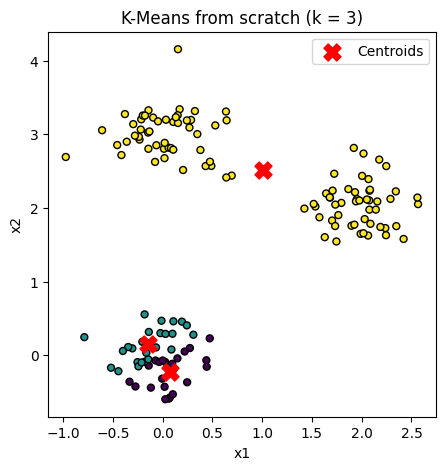

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=25, edgecolor="k")
plt.scatter(centroids[:, 0], centroids[:, 1],
            c="red", s=150, marker="X", label="Centroids")
plt.title("K-Means from scratch (k = 3)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


# Cell 7 – Compare with scikit-learn (optional but nice)

In [6]:
sk_kmeans = SkKMeans(n_clusters=3, n_init="auto", random_state=42)
sk_labels = sk_kmeans.fit_predict(X)
sk_inertia = sk_kmeans.inertia_
sk_sil = silhouette_score(X, sk_labels)

print("[Our K-Means]      inertia:", round(inertia, 4), " | silhouette:", round(sil, 4))
print("[sklearn KMeans]   inertia:", round(sk_inertia, 4), " | silhouette:", round(sk_sil, 4))


[Our K-Means]      inertia: 139.6542  | silhouette: 0.4401
[sklearn KMeans]   inertia: 25.7566  | silhouette: 0.7747


# Cell 8 – Summary (Markdown)

## Summary

- I generated a **small synthetic 2D dataset** with 3 Gaussian blobs.
- Implemented **K-Means from scratch** using NumPy:
  - Random centroid initialization
  - Assignment (closest centroid by Euclidean distance)
  - Update (mean of points in each cluster)
  - Convergence check based on centroid movement
- Evaluated the clustering using:
  - **Inertia** (sum of squared distances to closest centroid)
  - **Silhouette score** (how well-separated the clusters are)
- Visualized the clusters and centroids in 2D.
- Compared the results with `sklearn.cluster.KMeans` to confirm correctness.

This completes the “K-Means clustering from scratch” assignment using my own small dataset.
